In [5]:
from pathlib import Path
import pandas as pd, numpy as np
import joblib, json, pprint

DATA = Path("../MLPC2025_dataset")
meta = pd.read_csv(DATA/"metadata.csv")

sample_feat = np.load(DATA/"audio_features"/meta.loc[0, "filename"].replace(".mp3", ".npz"))
print("Available keys and shapes:")
pprint.pprint({k: sample_feat[k].shape for k in sample_feat})

n_frames = sample_feat[list(sample_feat.keys())[0]].shape[0]
duration = meta.loc[0, "end_time_s"] - meta.loc[0, "start_time_s"]
FRAME_LEN = duration / n_frames
print(f"\nComputed FRAME_LEN ≈ {FRAME_LEN:.4f} s")

Available keys and shapes:
{'bandwidth': (233, 1),
 'centroid': (233, 1),
 'contrast': (233, 7),
 'embeddings': (233, 768),
 'energy': (233, 1),
 'flatness': (233, 1),
 'flux': (233, 1),
 'melspectrogram': (233, 64),
 'mfcc': (233, 32),
 'mfcc_delta': (233, 32),
 'mfcc_delta2': (233, 32),
 'power': (233, 1),
 'zerocrossingrate': (233, 1)}

Computed FRAME_LEN ≈ 0.1199 s


In [6]:
total_frames = 0
for fname in meta.filename[:500]:          
    feat = np.load(DATA/"audio_features"/fname.replace(".mp3", ".npz"))
    total_frames += next(iter(feat.values())).shape[0]

avg_frames = total_frames / 500
mem_gb = avg_frames * len(meta) * 942 * 4 / 1e9
print(f"estimate size ≈ {mem_gb:.2f} GB")

estimate size ≈ 6.29 GB


In [8]:

GOOD_KEYS = ["melspectrogram", "mfcc", "mfcc_delta",
             "contrast", "centroid", "bandwidth", "flux",
             "zerocrossingrate", "energy"] 

def frame_matrix(feat_dict):
    mats = []
    for k in GOOD_KEYS:
        if k not in feat_dict:
            continue
        A = feat_dict[k]
        if A.ndim == 1:
            A = A[:, None]
        mats.append(A)
    return np.concatenate(mats, axis=1)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from pathlib import Path
Path("output_tang").mkdir(parents=True, exist_ok=True)

frame_samples = []
for fname in tqdm(meta.filename):
    feat = np.load(DATA/"audio_features"/fname.replace(".mp3", ".npz"))
    M = frame_matrix(feat)
    if M.shape[0] > 300:                      # 防爆内存随机采 300
        idx = np.random.choice(M.shape[0], 300, replace=False)
        M = M[idx]
    frame_samples.append(M)
frame_samples = np.vstack(frame_samples)
print("Aggregated frames:", frame_samples.shape)

scaler = StandardScaler().fit(frame_samples)
X_std  = scaler.transform(frame_samples)

pca1 = PCA(n_components=0.95, random_state=0).fit(X_std)
print("After PCA1, dims ->", pca1.n_components_)

joblib.dump(scaler, "output_tang/audio_scaler.pkl")
joblib.dump(pca1,  "output_tang/pca1_95.pkl")

/opt/miniconda3/envs/mlpc2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 9026/9026 [00:15<00:00, 579.29it/s]


Aggregated frames: (1684753, 140)
After PCA1, dims -> 62


['output_tang/pca1_95.pkl']

In [12]:
pca_target_dim = 50
pca2 = PCA(n_components=pca_target_dim, random_state=0).fit(pca1.transform(X_std))
print("PCA2 dims:", pca2.n_components_)

joblib.dump(pca2, "output_tang/pca2_50.pkl")

PCA2 dims: 50


['output_tang/pca2_50.pkl']

In [21]:
info = {
    "good_keys": GOOD_KEYS,
    "frame_len_sec": FRAME_LEN,
    "n_frames_sampled": int(frame_samples.shape[0]),
    "pca1_dim": int(pca1.n_components_),
    "pca1_var95": float(pca1.explained_variance_ratio_.sum()),
    "pca2_dim": pca2.n_components_
}
Path("output_tang").mkdir(exist_ok=True)
with open("output_tang/feature_selection_meta.json", "w") as fh:
    json.dump(info, fh, indent=2)
print("Saved meta:", info)

Saved meta: {'good_keys': ['melspectrogram', 'mfcc', 'mfcc_delta', 'contrast', 'centroid', 'bandwidth', 'flux', 'zerocrossingrate', 'energy'], 'frame_len_sec': np.float64(0.11989270386266092), 'n_frames_sampled': 1684753, 'pca1_dim': 62, 'pca1_var95': 0.9544001526711686, 'pca2_dim': 50}


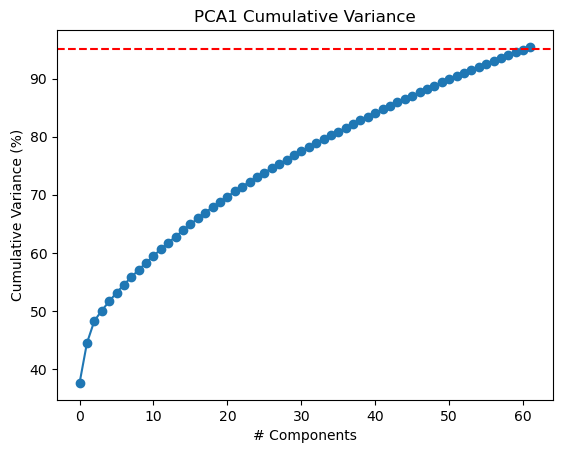

In [10]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca1.explained_variance_ratio_)*100, marker='o')
plt.axhline(95, color='r', ls='--')
plt.xlabel("# Components")
plt.ylabel("Cumulative Variance (%)")
plt.title("PCA1 Cumulative Variance")
plt.savefig("figs_tang/03_pca_cumulative_variance.pdf")
plt.show()

In [11]:
import joblib, numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

DATA     = Path("../MLPC2025_dataset")
OUTPUTS  = Path("output_tang")
OUTPUTS.mkdir(exist_ok=True)

meta = pd.read_csv(DATA/"metadata.csv")
ann  = pd.read_csv(DATA/"annotations.csv")

scaler = joblib.load(OUTPUTS/"audio_scaler.pkl")
pca1   = joblib.load(OUTPUTS/"pca1_95.pkl")
pca2   = joblib.load(OUTPUTS/"pca2_50.pkl")

GOOD_KEYS = json.load(open(OUTPUTS/"feature_selection_meta.json"))["good_keys"]
FRAME_LEN = json.load(open(OUTPUTS/"feature_selection_meta.json"))["frame_len_sec"]

def frame_matrix(feat_dict):
    mats=[]
    for k in GOOD_KEYS:
        A=feat_dict[k]
        if A.ndim==1: A=A[:,None]
        mats.append(A)
    return np.concatenate(mats,1)

def to_fixed_vec(frames):
    x = scaler.transform(frames)
    x = pca1.transform(x)
    return pca2.transform(x).mean(0)     

def complement_regions(on, off, dur):
    on, off = np.array(on), np.array(off)
    order = np.argsort(on); on, off = on[order], off[order]
    s0, s1, prev = [], [], 0.0
    for a,b in zip(on, off):
        if a>prev: s0.append(prev); s1.append(a)
        prev = max(prev,b)
    if prev<dur:  s0.append(prev); s1.append(dur)
    return s0, s1

vecs, labels, f_ids, regions = [], [], [], []

for fname, grp in tqdm(ann.groupby("filename")):
    feat = np.load(DATA/"audio_features"/fname.replace(".mp3",".npz"))
    M    = frame_matrix(feat)                    # (T,D)
    dur  = M.shape[0]*FRAME_LEN
    
    for _,row in grp.iterrows():
        i0, i1 = int(row.onset/FRAME_LEN), int(row.offset/FRAME_LEN)
        if i1-i0<1: continue
        vecs.append(to_fixed_vec(M[i0:i1]))
        labels.append(1)
        f_ids.append(fname); regions.append((row.onset,row.offset))
    
    s_on, s_off = complement_regions(grp.onset, grp.offset, dur)
    for a,b in zip(s_on, s_off):
        i0, i1 = int(a/FRAME_LEN), int(b/FRAME_LEN)
        if i1-i0<1: continue
        vecs.append(to_fixed_vec(M[i0:i1]))
        labels.append(0)
        f_ids.append(fname); regions.append((a,b))

vecs   = np.stack(vecs)        
labels = np.array(labels)
filenames = np.array(f_ids)                       
regions   = np.array(regions, dtype=object)       

np.savez(OUTPUTS / "audio_region_vectors.npz",
         vecs=vecs,
         is_event=labels,
         filenames=filenames,
         regions=regions)

print("Saved:", vecs.shape,
      "events:", labels.sum(),
      "silence:", (labels == 0).sum())

100%|██████████| 9026/9026 [00:27<00:00, 332.21it/s]


Saved: (51966, 50) events: 35723 silence: 16243


In [12]:
import numpy as np, joblib, matplotlib.pyplot as plt, seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data = np.load("output_tang/audio_region_vectors.npz", allow_pickle=True)
Z         = data["vecs"]          # (N, 50)
is_event  = data["is_event"]      # 0/1
filenames = data["filenames"]
regions   = data["regions"]
print("vectors:", Z.shape, "events:", is_event.sum(), "silence:", (is_event==0).sum())

vectors: (51966, 50) events: 35723 silence: 16243


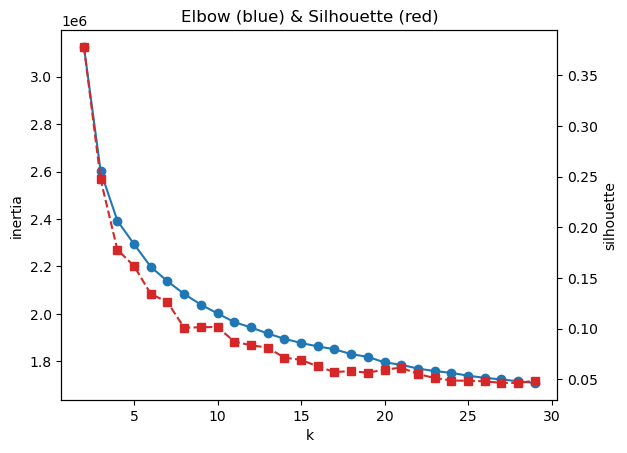

In [13]:
ks, inertias, sils = [], [], []
for k in range(2, 30):
    km = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(Z)
    ks.append(k)
    inertias.append(km.inertia_)                       
    sils.append(silhouette_score(Z, km.labels_))       

fig, ax1 = plt.subplots()
ax1.plot(ks, inertias, 'o-'); ax1.set_xlabel("k"); ax1.set_ylabel("inertia")
ax2 = ax1.twinx(); ax2.plot(ks, sils, 's--', color='tab:red'); ax2.set_ylabel("silhouette")
plt.title("Elbow (blue) & Silhouette (red)")
plt.savefig("figs_tang/03_elbow_silhouette.pdf")
plt.show()

In [14]:
k_final = 4                                
km = KMeans(n_clusters=k_final, random_state=0, n_init='auto').fit(Z)
c  = km.labels_

stat = []
for cid in range(k_final):
    idx   = c == cid
    size  = idx.sum()
    sil   = ((is_event == 0) & idx).sum()
    ratio = sil / size
    stat.append((cid, size, sil, ratio))
    print(f"cluster {cid}: size={size:5d}, silence={sil:5d} ({ratio:.1%})")


N = len(Z)
silence_clusters = [cid for cid, size, _, r in stat if (r > 0.8 and size > 0.1*N)]
print("Silence clusters:", silence_clusters or "None – no silence clusters found")

cluster 0: size=17944, silence= 3481 (19.4%)
cluster 1: size=15745, silence= 1775 (11.3%)
cluster 2: size= 6447, silence= 5387 (83.6%)
cluster 3: size=11830, silence= 5600 (47.3%)
Silence clusters: [2]


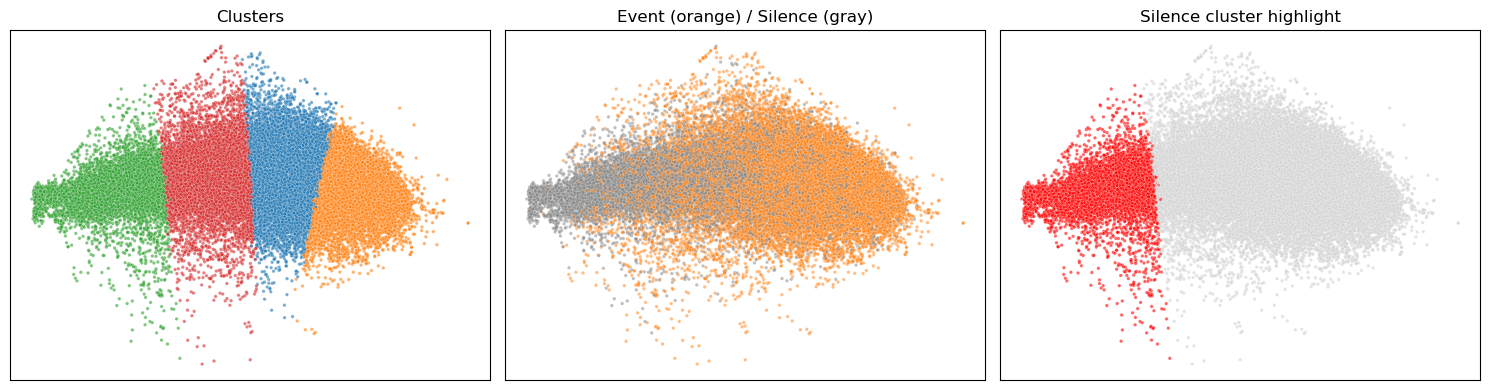

In [15]:
from sklearn.decomposition import PCA
p = PCA(n_components=2, random_state=0).fit_transform(Z)

fig, axs = plt.subplots(1,3, figsize=(15,4), sharex=True, sharey=True)

sns.scatterplot(ax=axs[0], x=p[:,0], y=p[:,1], hue=c,
                palette='tab10', s=6, alpha=.6, legend=None)
axs[0].set_title("Clusters")

sns.scatterplot(ax=axs[1], x=p[:,0], y=p[:,1], hue=is_event,
                palette=['gray','tab:orange'], s=6, alpha=.5, legend=False)
axs[1].set_title("Event (orange) / Silence (gray)")

mask = np.isin(c, silence_clusters)
sns.scatterplot(ax=axs[2], x=p[:,0], y=p[:,1], hue=mask,
                palette=['lightgray','red'], s=6, alpha=.6, legend=False)
axs[2].set_title("Silence cluster highlight")

for ax in axs: ax.set(xticks=[], yticks=[])

plt.tight_layout()
plt.savefig("figs_tang/03_pca_clusters.pdf")
plt.show()

In [53]:
import random, json
SAMPLES_PER_CLUSTER = 5
cluster_examples = {}

for cid in range(k_final):
    idx = np.where(c == cid)[0]
    chosen = random.sample(list(idx), min(SAMPLES_PER_CLUSTER, len(idx)))
    cluster_examples[cid] = [{
        "filename": filenames[i],
        "onset"   : float(regions[i][0]),
        "offset"  : float(regions[i][1]),
        "is_event": int(is_event[i])
    } for i in chosen]

with open("output_tang/cluster_examples.json", "w") as fh:
    json.dump(cluster_examples, fh, indent=2)

print("Saved 5 examples/cluster to cluster_examples.json")

Saved 5 examples/cluster to cluster_examples.json


In [2]:
cluster_semantic = {
    0: "background noise engines, traffic or machines",
    1: "rythmic sounds, doors, footsteps, or claps",
    2: "quiet environment, light sound or voices",
    3: "suprising sounds,high energy",
    
}
import json, pathlib
pathlib.Path("output_tang").mkdir(exist_ok=True, parents=True)
with open("output_tang/cluster_semantic.json", "w") as fh:
    json.dump(cluster_semantic, fh, indent=2)

In [3]:

import numpy as np
from sklearn.cluster import KMeans

audio = np.load("output_tang/audio_region_vectors.npz", allow_pickle=True)
Z        = audio["vecs"]        # (N, 50)
is_event = audio["is_event"]    # (N,)

k_audio = 4
km_audio = KMeans(k_audio, random_state=0, n_init='auto').fit(Z)
a_cluster = km_audio.labels_

np.savez("output_tang/region_clusters.npz",
         cluster=a_cluster,
         is_event=is_event)

print("region_clusters.npz written:", np.unique(a_cluster, return_counts=True))

region_clusters.npz written: (array([0, 1, 2, 3], dtype=int32), array([17944, 15745,  6447, 11830]))
